# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, we will compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.


In [ ]:
# TODO: Total number of records
n_records = len(data.index)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'].index)

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'].index)

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100.0 * n_greater_50k / n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data

### Transforming Skewed Continuous Features
Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. Below we plot a histogram of the two features '`capital-gain'` and `'capital-loss'`:

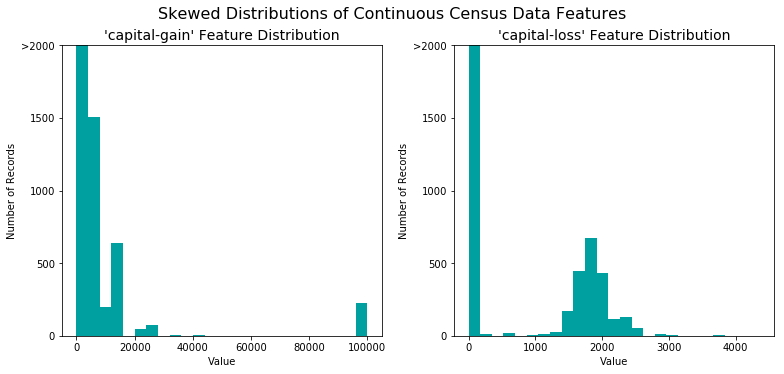

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

We will apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

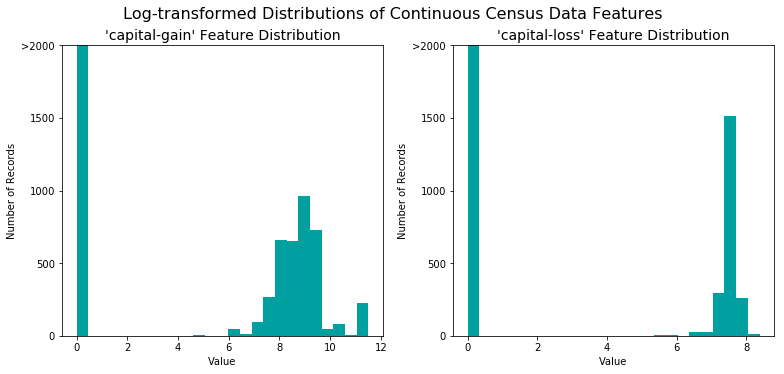

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, we need to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners.

Below we use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Data Preprocessing

As learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. Here we convert categorical variables by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. 

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

 - We use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - We convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = None

# Encode the 'income_raw' data to numerical values
income = ( income_raw == '>50K' ).astype(int)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [ ]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision.

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [9]:
# Calculate accuracy
y_pred = pd.Series(np.ones(income.shape[0]), name='y_pred')
df = pd.concat([pd.Series(np.array(income), name='y_test'), y_pred], axis=1)

# Computing false/true positives/negatives
df['tp'] = df.apply(lambda x: x['y_pred']==1 and x['y_test']==1, axis=1)
df['tn'] = df.apply(lambda x: x['y_pred']==0 and x['y_test']==0, axis=1)
df['fp'] = df.apply(lambda x: x['y_pred']==1 and x['y_test']==0, axis=1)
df['fn'] = df.apply(lambda x: x['y_pred']==0 and x['y_test']==1, axis=1)

n_size = 1.0 * income.shape[0]

tp = df['tp'].sum() / n_size
tn = df['tn'].sum() / n_size
fp = df['fp'].sum() / n_size
fn = df['fn'].sum() / n_size

accuracy = 1.0 * (tn + tp)

# Calculate F-score using the formula above for beta = 0.5
beta = 0.5
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
fscore = (1+beta**2)*precision*recall/(((beta**2)*precision)+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

# [NOTE] confirmed by the following:
# from sklearn.metrics import fbeta_score, accuracy_score
# print accuracy_score(y_test, y_pred)
# print fbeta_score(y_test, y_pred, 0.5)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html):**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

As we perform **classification** on labeled data, the most useful algorithms in my opinion are the following:

Decision Trees:
- I personally use decision trees on a daily basis in the industry to perform predicitve maintenance for aircraft. A given system comprises multiple sensors on which we compute several kpis for each flight. Given a history of operational failures, we are able to label flights as OK/KO. We compute a decision tree to set thresholds on these kpis that allow us to determine system degradation.
- One of the most important advantages of decision trees is that it automatically selects the most important variables of the dataset (which we can find on top of the tree) based on information gain, as well as split thresholds. It it also a very visual solution that can be easily explained.
- A decision tree with a lot of data and variables can easily overfit and we can find ourselves with lots and lots of leaves if we don't set a limit in depth. For the same reason it is extremely sensitive to slight changes in the data. Also, splits are performed on numerical values only, so the dataset must be preprocessed prior to building the tree.
- Given those reasons, I believe that building a tree on a dataset with 100+ variables and with 50K samples is more than viable


Stochastic Gradient Descent Classifier:
- Gradient descent is itself implemented in several algorithms such as artificial neural networks (through the backpropagation equation), which itself is used for example to perform text or speech recognition. It also has many applications in various companies where a quality management system is in place. Indeed, the aim is to loop and correct several processes through observations and correction implementation and monitoring, which is exactly the heart of the algorithm. *Application of Stochastic Gradient Descent Algorithm in Evaluating the Performance Contribution of Employees, Ratnayake et al, IOSR Journal of Business and Management, Jun 2014*
- SGDs are very efficient when it comes to large datasets. The basic version is very easy to implement and it can be easily fine-tuned with a lot of hyperparameters.
- This number of hyperparameters can also be a drawback, as the classifier can become very sensitive to some of them. It is also sensitive to feature scaling.
- As we face a classification problem with labeled data on a medium-size dataset, and as we have already scaled and preprocessed our data, I think SGDs would also make a great candidate.


Support Vector Machines:
- SVMs are used in the oil industry, and specifically in refineries, where a lot of data is at stake and decision-making is crucial. The method is used for example to classify gasoline given its physical properties. Source: *Applications of support vector machines in oil refineries: A survey, Saybani et al, International Journal of the Physical Sciences, November 2nd, 2011*
- SVMs work well in complicated domains (higher dimensional spaces), when there is no clear margin of separation in lower dimensional spaces. In order to do this, one can use the kernel trick method, which is the computation of the dot product only in that given higher dimensional space.    
- Performance decreases as the dataset grows in size (computational time) and as the number of features grows. Noise also affects margin a lot and can penalize performance. Also prone to overfitting.
- Given the fact that we don't have that many samples (45K), and that we face a classification problem with labeled data, I think SVMs would make a great candidate.


### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we have chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.
In the code block below, we will implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [10]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:int(sample_size)], y_train[:int(sample_size)])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    beta = 0.5
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Initial Model Evaluation
In the code cell, we implement the following:
- Import the three supervised learning models we've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - **Note:** We will use the default settings for each model — and tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.


SGDClassifier trained on 362.0 samples.
SGDClassifier trained on 3618.0 samples.
SGDClassifier trained on 36177 samples.
DecisionTreeClassifier trained on 362.0 samples.
DecisionTreeClassifier trained on 3618.0 samples.
DecisionTreeClassifier trained on 36177 samples.


C:\Users\patrick_marshall\AppData\Local\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 362.0 samples.
SVC trained on 3618.0 samples.
SVC trained on 36177 samples.


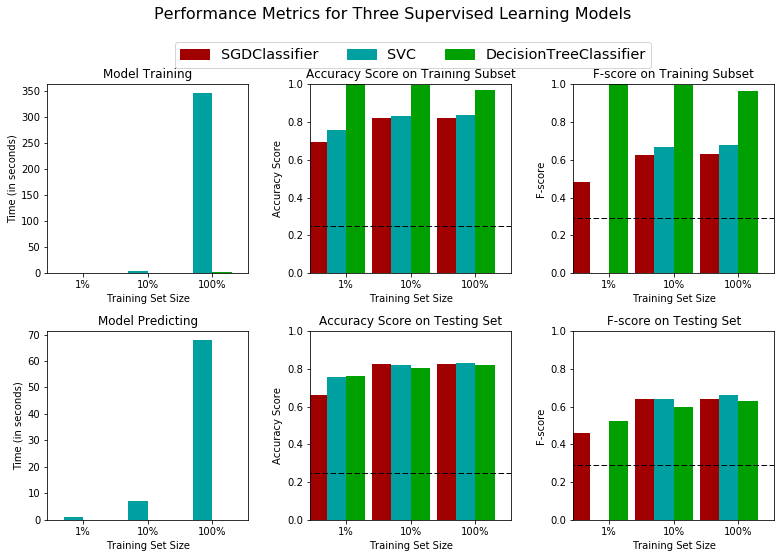

In [11]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Initialize the three models
clf_A = SGDClassifier(random_state=7)
clf_B = DecisionTreeClassifier(random_state=19)
clf_C = SVC(random_state=42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
train_size = len(X_train)
samples_1 = round(1.0*train_size/100)
samples_10 = round(10.0*train_size/100)
samples_100 = train_size

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

Given the results, prediction and training time immediately rule out an svm-based learning model (at least on my laptop configuration). I think this can be explained by the high number of features and therefore the dimensionality. The algorithm has not been tuned in any form.

We would expect the decision tree to overfit naturally on the training set. We can observe that the hypothesis is true: the accuracy and f scores are close to 1 on the training set, and they both drop to respectively 0.8 and 0.64 on the testing set. This can be easily finetuned with some of the algorithm's hypermarameters (i.e depth), that would allow us to to find a better tradeoff between training and testing set scores.

The results are pretty much the same with the SGD classifier, but it tends to overfit less and provide us with a more generalized model, given the accuracy of the training test. The accuracy of the testing set is also quite high (above 0.8), which makes us believe that the algorithm has already converged to a good model, without any tuning.

As CharityML wishes to emphasize precision and target precisely people who make more than $50K, I would go for the algorithm that yields the highest f-score on the testing set in reasonable time, and that is the SGD.

### Describing the Model

CharityML chose to emphasize precision and accurately target people who make more than 50K based on a set of features such as age, job... The model that we chose is the one that returns the best accuracy and precision within an acceptable runtime.

This model basically draws a "line" between a representation of the samples, then iteratively adjusts itself in order to reduce the error of a candidate being placed on the wrong side of that line, using a penalty system. Once the model converges to a stable line, and given a new sample, we can easily determine on which side of the line it end up.

### Model Tuning
In this section we use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. We will:

- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier we have chosen and store it in `clf`.
- Create a dictionary of parameters we wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [12]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import SGDClassifier

# Initialize the classifier
clf = SGDClassifier(random_state=7)

# Create the parameters list we wish to tune
parameters = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 
              'penalty': ['none', 'l2', 'l1', 'elasticnet']}

# Make a fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

C:\Users\patrick_marshall\AppData\Local\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8255
F-score on testing data: 0.6403

Optimized Model
------
Final accuracy score on the testing data: 0.8421
Final F-score on the testing data: 0.6769


### Final Model Evaluation

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |           0.2478    |        0.8255     |   0.8421        |
| F-score        |           0.2917    |        0.6403     |   0.6769        |


As we would expect, the scores obtained through a grid search optimization are better than what we had on a non tuned model. Grid search found a couple of parameters that allowed our accuracy to improve by 2% and our f-score to improve by 3.6%, which does not seem much but can be highly significant at the scale of money collected by CharityML ! 

Fiding the right model and tuning it allowed the accuracy to be multiplied by 3 and f-score by more than 2 compared to a naive approach. Needless to say that a machine learning approach has its importance

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Feature Relevance Observation

To my mind, the most important features (based on observations) are the following:

- Age:  the older, the more work experience you get, the more paid you become
- Education level and number of years: someone with a Phd or masters degree will most likely access higher responsibilities quicker, therefore get paid more 
- Hours per week: with a "linear" assumption, the more you work, the more you get paid
- Marital status: when you have a family to provide for, you are more likely to be set up and have a stable job, therefore a more stable income

### Extracting Feature Importance
Here we choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, we implement the following:
 - Import a supervised learning model from sklearn
 - Train the supervised model on the entire training set
 - Extract the feature importances using `'.feature_importances_'`.

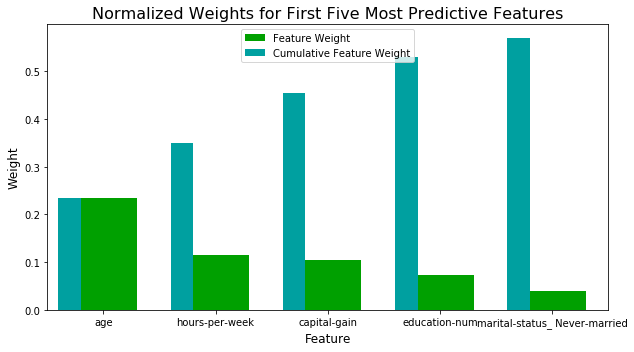

In [13]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Train the supervised model on the training set 
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

The visualization obtained above confirms that I was right about age, marital status, number of hours worked per week and education (in number of years). However, given "quick" observation of the data, I could not see that capital-gain was an important feature, but it totally makes sense as you are more likely to make yourself a good capital when earning more money.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [14]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8421
F-score on testing data: 0.6769

Final Model trained on reduced data
------
Accuracy on testing data: 0.8165
F-score on testing data: 0.6232


### Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

The scores obtained on reduced data are very high, only just a bit lower (respectively 1% and 1.9%) than the ones obtained with full optimization, but with a training time that is much improved (only 5 columns used instead of 103). For this reason, I would definitely consider using the reduced dataset instead of the full one, as the additionnal computation time only serves the 1% improvement (a ratio would have to be made).